In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import joblib

# Mis utilitarios
from utils import *


In [3]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate, ConvLSTM2D, Reshape, Conv2D, Lambda
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

# Set Path

In [4]:
el_path_main = Path(os.getcwd()).parent
el_path_main

WindowsPath('e:/backup Asus G15 27_10_2021/Colegio de Mates Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting')

In [5]:
# En caso sea en google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# Load Tensors

In [6]:
X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = joblib.load(el_path_main / '2. Datos/Processed data/TRAIN_data.pkl')
X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_data.pkl')

# El orden de los inputs en X_gts_train es:
# ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']

In [7]:
# Reducimos el tamaño del dataset para que pueda ser ejecutado en local (no  sirvió, pero en Cloud sí)
desde_index = 700
X_gts_train = X_gts_train[desde_index:,:]
Y_train = Y_train[desde_index:,:]
X_gts_miss_train = X_gts_miss_train[desde_index:,:]
X_ctry_lvl_train = X_ctry_lvl_train[desde_index:,:]

In [8]:
# X_gts_train.shape, Y_train.shape, X_gts_miss_oot.shape, X_ctry_lvl_oot.shape
X_gts_train.shape, Y_train.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((477, 10, 96, 36, 28), (477, 12, 36, 28), (477, 10, 96, 36, 28), (477, 180))

In [9]:
def format_Y(Y):
    """
    Formatea Y para que sea un array de numpy con la forma (n_samples, n_classes)
    """
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes=2)
    return Y

In [11]:
Y_train_f = format_Y(Y_train)
Y_oot_f = format_Y(Y_oot)

In [12]:
X_gts_train.shape, Y_train.shape, Y_train_f.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((477, 10, 96, 36, 28),
 (477, 12, 36, 28),
 (477, 12, 36, 28, 2),
 (477, 10, 96, 36, 28),
 (477, 180))

In [12]:
def gen_X_gts_for_model(X_gts, X_gts_miss):
    n_vars = X_gts.shape[1]
    lista_array = []
    for var in range(n_vars):
        X_tmp      = np.expand_dims(X_gts[:, var, :], -1)
        X_tmp_miss = np.expand_dims(X_gts_miss[:, var, :], -1)
        X = np.concat((X_tmp, X_tmp_miss), axis=-1)
        lista_array.append(X)
    return lista_array

In [13]:
la_lista_de_arrays_oot = gen_X_gts_for_model(X_gts_oot, X_gts_miss_oot)
la_lista_de_arrays_train = gen_X_gts_for_model(X_gts_train, X_gts_miss_train)

In [ ]:
la_lista_de_arrays_train[0].shape

(477, 96, 36, 28, 2)

# Version Simple

In [ ]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2   
n_filters = 2
kernel_size = 3
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [15]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [ ]:
mi_inp_gts = Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts')
mi_inp_ctry = Input(shape=(vars_ctry_lvl, ), name=f'input_ctry')

mi_lstm = ConvLSTM2D(filters=n_filters,
                     kernel_size=(kernel_size, kernel_size),
                     padding='same',
                     data_format = 'channels_last',
                     return_sequences=False,
                     recurrent_dropout=recurrent_dropout,
                     dropout=dropout,
                     name='conv_lstm_1')(mi_inp_gts)

mi_dense_ctry = Dense(36*28, activation='relu')(mi_inp_ctry)
mi_dense_ctry = Reshape((36, 28, 1))(mi_dense_ctry)

mi_encoded = Concatenate(axis=-1)([mi_lstm, mi_dense_ctry])
mi_encoded = Reshape((1, n_lats, n_lons, 3))(mi_encoded)
mi_encoded = Lambda(repeat_latent)(mi_encoded)

mi_decoder = ConvLSTM2D(filters=n_filters,
                        kernel_size=(kernel_size, kernel_size),
                        padding='same',
                        data_format = 'channels_last',
                        return_sequences=True,
                        recurrent_dropout=recurrent_dropout,
                        dropout=dropout,
                        name='conv_lstm_2')(mi_encoded)
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(mi_decoder)
# Model
mi_simple_model = Model(inputs=[mi_inp_gts, mi_inp_ctry], outputs=output)
mi_simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mi_simple_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry          │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts           │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1008)      │    182,448 │ input_ctry[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_1         │ (None, 36, 28, 2) │        296 │ input_gts[0][0]   │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 36, 28, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 28, 3) │          0 │ conv_lstm_1[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 36, 28, │          0 │ concatenate[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 12, 36,    │          0 │ reshape_1[0][0]   │
│                     │ 28, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_2         │ (None, 12, 36,    │        368 │ lambda[0][0]      │
│ (ConvLSTM2D)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 36,    │          6 │ conv_lstm_2[0][0] │
│ (TimeDistributed)   │ 28, 2)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,118 (715.30 KB)

 Trainable params: 183,118 (715.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mi_simple_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

mi_simple_model_history = mi_simple_model.fit(x = [la_lista_de_arrays_train[9], X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.2,
                        batch_size=128,
                        epochs=20,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7760 - loss: 0.6810 - val_accuracy: 0.8446 - val_loss: 0.6561
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 996ms/step - accuracy: 0.7927 - loss: 0.6674 - val_accuracy: 0.8467 - val_loss: 0.6452
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 955ms/step - accuracy: 0.8014 - loss: 0.6565 - val_accuracy: 0.8613 - val_loss: 0.6347
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 931ms/step - accuracy: 0.8130 - loss: 0.6469 - val_accuracy: 0.8645 - val_loss: 0.6260
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 943ms/step - accuracy: 0.8197 - loss: 0.6381 - val_accuracy: 0.8744 - val_loss: 0.6180
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step - accuracy: 0.8292 - loss: 0.6295 - val_accuracy: 0.8797 - val_loss: 0.6109
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - accuracy: 0.8354 - loss: 0.6213 - val_accuracy: 0.8875 - val_loss: 0.6028
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 964ms/step - accuracy: 0.8399 - loss: 0.6138 - val_accuracy: 0.9065 - val_loss: 0

In [ ]:
mi_simple_model.save_weights(el_path_main/'4. Analisis/mi_simple_model.weights.h5')

# Conv-LSTM

In [14]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2   
n_filters = 2
kernel_size = 3
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [15]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [16]:
# Inputs for each variable from GTS    
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent) 
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,896 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2016)      │     34,272 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 36, 28, 2) │        296 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 36, 28, 2) │        296 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 36, 28, 2) │        296 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 36, 28, 2) │        296 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 40,828 (159.48 KB)

 Trainable params: 40,828 (159.48 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [ ]:
history = model.fit(x = la_lista_de_arrays_train + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.2,
                        batch_size=128,
                        epochs=20,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/20


In [ ]:
model.save_weights(el_path_main/'4. Analisis/model.weights.h5')

# Load Models

In [15]:
n_vars_from_gts = X_gts_oot.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_oot.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_oot.shape[3] # N of latitudes
n_lons = X_gts_oot.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_oot.shape[1] # N of variables from country level data
n_codmes_fcast = Y_oot.shape[1] # N of codmes for forecast


## Define Archiecture

### Simple Model

In [34]:
# Set of parameters that will be tunned
recurrent_dropout = 0.6
dropout = 0.6
n_filters = 2
kernel_size = 6
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis


mi_inp_gts = Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts')
mi_inp_ctry = Input(shape=(vars_ctry_lvl, ), name=f'input_ctry')

mi_lstm = ConvLSTM2D(filters=n_filters,
                     kernel_size=(kernel_size, kernel_size),
                     padding='same',
                     data_format = 'channels_last',
                     return_sequences=False,
                     recurrent_dropout=recurrent_dropout,
                     dropout=dropout,
                     name='conv_lstm_1')(mi_inp_gts)

mi_dense_ctry = Dense(36*28, activation='relu')(mi_inp_ctry)
mi_dense_ctry = Reshape((36, 28, 1))(mi_dense_ctry)

mi_encoded = Concatenate(axis=-1)([mi_lstm, mi_dense_ctry])
mi_encoded = Reshape((1, n_lats, n_lons, 3))(mi_encoded)
mi_encoded = Lambda(repeat_latent)(mi_encoded)

mi_decoder = ConvLSTM2D(filters=n_filters,
                        kernel_size=(kernel_size, kernel_size),
                        padding='same',
                        data_format = 'channels_last',
                        return_sequences=True,
                        recurrent_dropout=recurrent_dropout,
                        dropout=dropout,
                        name='conv_lstm_2')(mi_encoded)
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(mi_decoder)
# Model
mi_simple_model = Model(inputs=[mi_inp_gts, mi_inp_ctry], outputs=output)
mi_simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Complex Model

In [35]:
# Set of parameters that will be tunned
recurrent_dropout = 0.6
dropout = 0.6
n_filters = 2
kernel_size = 6
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [36]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [37]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
complex_model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
complex_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Load Weights

In [39]:
# Ejecución en Google Colab (Ver 04_Model_Estimation_GoogleColab_v1.ipynb y 04_Model_Estimation_GoogleColab_v2.ipynb)
mi_simple_model.load_weights(el_path_main/'4. Analisis/mi_simple_model_menos_datos_v2.weights.h5')
complex_model.load_weights(el_path_main/'4. Analisis/ModeloGrande_v3.weights.h5')

e:\backup Asus G15 27_10_2021\Colegio de Mates Bourbaki\DLA2501 - Deep Learning Avanzado\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
e:\backup Asus G15 27_10_2021\Colegio de Mates Bourbaki\DLA2501 - Deep Learning Avanzado\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
y_hat_simple_oot = mi_simple_model.predict([la_lista_de_arrays_oot[9], X_ctry_lvl_oot], verbose=1)
y_hat_complex_oot = complex_model.predict(la_lista_de_arrays_oot + [X_ctry_lvl_oot], verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


In [41]:
joblib.dump((y_hat_simple_oot, y_hat_complex_oot), el_path_main / '2. Datos/Processed data/OOT_Y_Hat_simple_and_complex_models.pkl')

['e:\\backup Asus G15 27_10_2021\\Colegio de Mates Bourbaki\\DLA2501 - Deep Learning Avanzado\\Flood forecasting\\2. Datos\\Processed data\\OOT_Y_Hat_simple_and_complex_models.pkl']

In [22]:
joblib.dump(y_hat_complex_oot, el_path_main / '2. Datos/Processed data/OOT_Y_Hat_complex_model_v3.pkl')

['e:\\backup Asus G15 27_10_2021\\Colegio de Mates Bourbaki\\DLA2501 - Deep Learning Avanzado\\Flood forecasting\\2. Datos\\Processed data\\OOT_Y_Hat_complex_model_v3.pkl']

# Benchmark (Logit)

In [62]:
# Load Arrays
X_bench_train, Y_bench_train = joblib.load(el_path_main / '2. Datos/Processed data/TRAIN_data_bench.pkl')
X_bench_oot, Y_bench_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_data_bench.pkl')

In [64]:
X_bench_train.shape, Y_bench_train.shape

((1282176, 27), (1282176, 1))

In [65]:
X_bench_train = X_bench_train[1_000_000:]
Y_bench_train = Y_bench_train[1_000_000:]

In [66]:
X_bench_train.shape, Y_bench_train.shape

((282176, 27), (282176, 1))

In [67]:
X_bench_oot.shape, Y_bench_oot.shape

((193536, 27), (193536, 1))

In [71]:
size_grilla = 2

min_l1_ratio, max_l1_ratio = 0, 1
min_c, max_c = 0, 20
dict_params_range = {
    'l1_ratio'    : [min_l1_ratio, max_l1_ratio],
    'C'           : [min_c, max_c]
}
dict_params_lhs = sudoku_grid(
    params_dict   = dict_params_range, 
    size_grilla   = size_grilla,
    must_be_int   = [] 
)

# Ad-hoc hyperparametrs
dict_params_lhs['class_weight'] = [None, 'balanced']
dict_params_lhs['penalty']      = ['elasticnet']
dict_params_lhs['solver']       = ['saga']
dict_params_lhs

Discrepancia rnd: 0.2606384552053711
Discrepancia lhs: 0.1138585335681701
La cambio en "discrepancia" vs un random sampling es: -56.32%


{'l1_ratio': [np.float64(0.8921629508620382), np.float64(0.4706296220153559)],
 'C': [np.float64(11.167693415685797), np.float64(7.812627880188023)],
 'class_weight': [None, 'balanced'],
 'penalty': ['elasticnet'],
 'solver': ['saga']}

In [72]:
grilla_hypetun = ParameterGrid(dict_params_lhs)
len(grilla_hypetun)

8

In [73]:
simple_model_logit = LogisticRegression(random_state=0)
simple_model_logit_gs = GridSearchCV(simple_model_logit, dict_params_lhs, cv = 5, n_jobs = -1)
simple_model_logit_gs.fit(X_bench_train, Y_bench_train.ravel())


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [np.float64(11.167693415685797),
                               np.float64(7.812627880188023)],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [np.float64(0.8921629508620382),
                                      np.float64(0.4706296220153559)],
                         'penalty': ['elasticnet'], 'solver': ['saga']})

In [74]:
pd.DataFrame(simple_model_logit_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_l1_ratio,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,28.479902,0.380517,0.010359,0.000791,11.167693,None,0.892163,elasticnet,saga,"{'C': 11.167693415685797, 'class_weight': None...",0.946098,0.947462,0.942589,0.947727,0.948755,0.946526,0.002143,3
1,23.868005,2.443945,0.015373,0.013204,11.167693,None,0.470630,elasticnet,saga,"{'C': 11.167693415685797, 'class_weight': None...",0.946063,0.947462,0.942571,0.947727,0.948755,0.946516,0.002151,4
2,28.535393,0.679001,0.010419,0.001408,11.167693,balanced,0.892163,elasticnet,saga,"{'C': 11.167693415685797, 'class_weight': 'bal...",0.703381,0.605032,0.891610,0.807283,0.831257,0.767713,0.101546,7
3,29.753729,0.838599,0.012033,0.003871,11.167693,balanced,0.470630,elasticnet,saga,"{'C': 11.167693415685797, 'class_weight': 'bal...",0.781186,0.933995,0.763994,0.729104,0.720138,0.785683,0.077439,6
4,30.418146,0.680410,0.011662,0.002932,7.812628,None,0.892163,elasticnet,saga,"{'C': 7.812627880188023, 'class_weight': None,...",0.946098,0.947479,0.942571,0.947727,0.948773,0.946530,0.002155,2
5,24.651586,3.767192,0.008908,0.000372,7.812628,None,0.470630,elasticnet,saga,"{'C': 7.812627880188023, 'class_weight': None,...",0.946063,0.947479,0.942589,0.947763,0.948879,0.946555,0.002177,1
6,27.498486,2.898936,0.007812,0.001993,7.812628,balanced,0.892163,elasticnet,saga,"{'C': 7.812627880188023, 'class_weight': 'bala...",0.719062,0.656525,0.924940,0.750456,0.670648,0.744326,0.096369,8
7,24.038601,0.636260,0.004705,0.000513,7.812628,balanced,0.470630,elasticnet,saga,"{'C': 7.812627880188023, 'class_weight': 'bala...",0.665090,0.946859,0.877629,0.810082,0.798476,0.819627,0.093779,5


In [75]:
best_benchmark_model = simple_model_logit_gs.best_estimator_

In [76]:
best_benchmark_model.intercept_

array([-10.85847415])

In [77]:
XB_hat_benchmark_oot = (np.ones(X_bench_oot.shape[0])*best_benchmark_model.intercept_).reshape(-1,1) + X_bench_oot@best_benchmark_model.coef_.T
Y_hat_benchmark_oot = (1/(1+np.exp(-XB_hat_benchmark_oot)))

In [78]:
joblib.dump((Y_hat_benchmark_oot), el_path_main / '2. Datos/Processed data/OOT_Y_hat_benchmark.pkl')

['e:\\backup Asus G15 27_10_2021\\Colegio de Mates Bourbaki\\DLA2501 - Deep Learning Avanzado\\Flood forecasting\\2. Datos\\Processed data\\OOT_Y_hat_benchmark.pkl']

In [79]:
mi_gini(Y_bench_oot, Y_hat_benchmark_oot)

np.float64(0.8038809141642644)

# Model Evaluation

In [80]:
y_hat_simple_oot, y_hat_complex_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_Y_Hat_simple_and_complex_models.pkl')
Y_hat_benchmark_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_Y_hat_benchmark.pkl')

In [81]:
y_hat_simple_oot.shape, y_hat_complex_oot.shape, Y_hat_benchmark_oot.shape, Y_oot.shape

((193, 12, 36, 28, 2), (193, 12, 36, 28, 2), (193536, 1), (193, 12, 36, 28))

In [91]:
time_step_pred = 12
el_th = 0.5
# Transform of NN models predictions
# y_hat_simple_oot_12m = y_hat_simple_oot[:,time_step_pred-1,:,:, 1].ravel()
# y_hat_complex_oot_12m = y_hat_complex_oot[:,time_step_pred-1,:,:, 1].ravel()
# Y_oot_12m = Y_oot[:,time_step_pred-1,:,:].ravel()

y_hat_simple_oot_12m = y_hat_simple_oot[:,:,:,:, 1].ravel()
y_hat_complex_oot_12m = y_hat_complex_oot[:,:,:,:, 1].ravel()
Y_oot_12m = Y_oot[:,:,:,:].ravel()

In [92]:
y_hat_simple_oot_12m.shape, y_hat_complex_oot_12m.shape, Y_oot_12m.shape

((2334528,), (2334528,), (2334528,))

In [93]:
mi_gini(Y_bench_oot, Y_hat_benchmark_oot)

np.float64(0.8038809141642644)

In [94]:
mi_gini(Y_oot_12m, y_hat_simple_oot_12m)

np.float64(0.11022086421076627)

In [95]:
mi_gini(Y_oot_12m, y_hat_complex_oot_12m)

np.float64(0.11221710032626486)

In [96]:
mi_acu(Y_oot_12m, np.where(y_hat_complex_oot_12m>=el_th, 1, 0))

0.9456271246264769

In [97]:
mi_acu(Y_oot_12m, np.where(y_hat_simple_oot_12m>=el_th, 1, 0))

0.9033033658195575

In [98]:
mi_acu(Y_bench_oot, np.where(Y_hat_benchmark_oot>=el_th, 1, 0))

0.951182208994709

In [99]:
df_gts_reescal = pd.read_csv(el_path_main / '2. Datos/Main gridded data/consol_df_peru_reescal.csv')
los_lons = df_gts_reescal['lon'].unique()
las_lats = df_gts_reescal['lat'].unique()

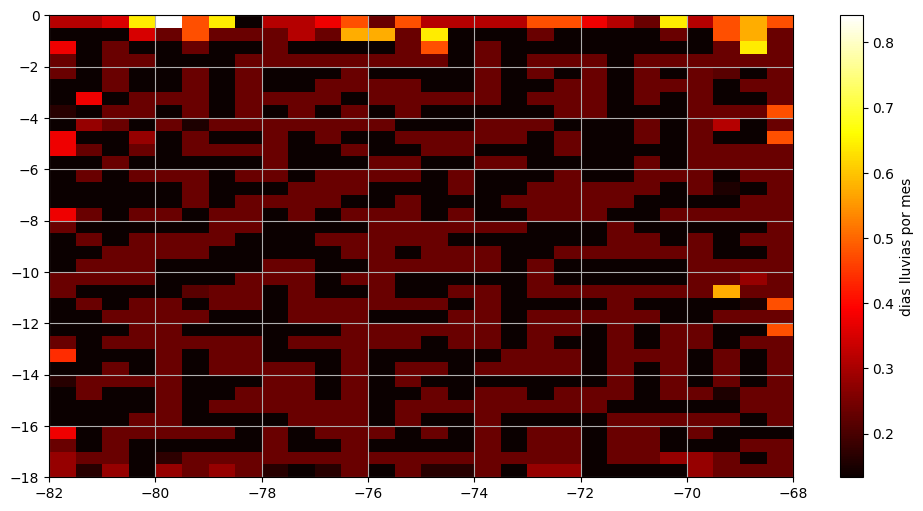

In [103]:
_lon_per, _lat_per = np.meshgrid(los_lons,
                                 las_lats)
_frs_peru = y_hat_complex_oot[0,11,:,:,1]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon_per, _lat_per, _frs_peru, shading='auto', cmap='hot')
plt.colorbar(label='dias lluvias por mes')
plt.grid()